<Axes: >

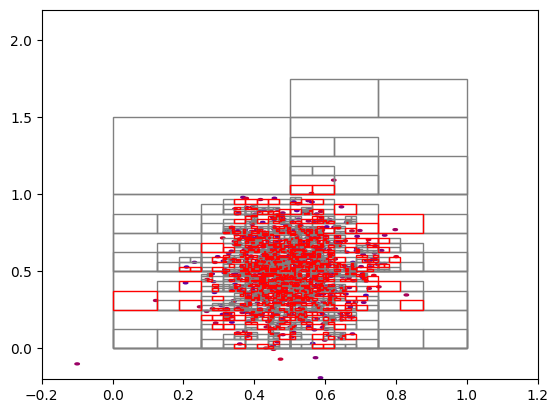

In [161]:
'''
This notebook is intended to make a prototype for the barnes huts algorithm.
'''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def sigmoidColorMap(x: float, steepness: float, shift: float) -> float:
    ''' Maps (0, inf) to (0, 1) using a sigmoid function. '''
    exp_term = np.exp(-x / steepness + shift / steepness)
    return 1 / (1 + exp_term)

class Particle:
    __slots__ = ('x', 'v', 'F', 'mass', '_radius')
    density: float = 1000
    distanceScale: float = 1e-2

    def __init__(self, x: np.ndarray, v: np.ndarray, mass: float):
        self.x = x
        self.v = v
        self.F = np.zeros(2)
        self.mass = mass
        self._radius = (3 / (4 * np.pi) * self.mass / self.density) ** (1 / 3)  # Precompute radius

    @property
    def a(self) -> np.ndarray:
        return self.F / self.mass

    @property
    def radius(self) -> float:
        return self._radius  # Use precomputed value
    
    @property
    def drawRadius(self) -> float:
        return int(self.radius * self.distanceScale)
    
    @property
    def scaledX(self) -> np.ndarray:
        return (self.x * self.distanceScale).astype(int)

    @property
    def color(self) -> tuple:
        RED = (1, 0, 0)
        BLUE = (0, 0, 1)
        scale = sigmoidColorMap(np.linalg.norm(self.v), 10, 10)
        return (RED[0] * scale + BLUE[0] * (1 - scale),
                RED[1] * scale + BLUE[1] * (1 - scale),
                RED[2] * scale + BLUE[2] * (1 - scale))


# class Node:
#     def __init__(self, position: np.ndarray, width: float, height:float):
#         self.position:np.ndarray = position
#         self.width:float = width
#         self.height:float = height
#         self.children:list[Node]=[None,None,None,None]
#         self.particle:Particle = None

#         halfWidth = width/2
#         halfHeight = height/2
#         self.OFFSETS = [np.array([0,0]),np.array([halfWidth,0]),np.array([0,halfHeight]),np.array([halfWidth,halfHeight])]
    
#     def this(self,*args,**kwargs)->'Node':
#         # calling constructor within self. 
#         # Reason for this is to allow for easier inheritance
#         # in subdivide, makes new Node, but when subclassed by GravitationalNode, it should return a GravitationalNode
#         return self.__class__(*args,**kwargs)        

#     @property
#     def corners(self)->list[np.ndarray]:
#         '''
#         return a list of vectors representing the vertices
#         '''
#         return [self.position, self.position+np.array([self.width,0]), self.position+np.array([0,self.height]), self.position+np.array([self.width,self.height])]
    
#     @property
#     def leaves(self)->list['Node']:
#         if self.particle is not None:
#             return [self]
        
#         return [leaf for child in self.children if child is not None for leaf in child.leaves] 
#     @property
#     def allChildren(self) -> list['Node']:
#         if not any(self.children):  # No children exist
#             return [self]

#         res = [self]
#         for child in self.children:
#             if child is not None:
#                 res.extend(child.allChildren)  # Correct recursive call

#         return res
    
#     def insert(self,particle:Particle)->None:
#         if self.isOutOfBounds(particle):
#             return
#         elif self.particle is None and not any(self.children):
#             self.particle = particle
#             return
#         if self.particle is not None:
#             self.subdivide()
#             self.moveToChildren(self.particle)
#             self.particle = None

#         self.moveToChildren(particle)
    
#     def subdivide(self):
#         for i in range(4):
#             if self.children[i] is None:
#                 self.children[i] = self.this(self.position+self.OFFSETS[i],self.width/2,self.height/2)

#     def moveToChildren(self,particle:Particle):
#         for child in self.children:
#             if child is None:
#                 continue
#             if child.isOutOfBounds(particle):
#                 continue
#             child.insert(particle)
#             break

#     def isOutOfBounds(self,particle:Particle)->bool:
#         return not (
#                     (particle.x[0]>=self.position[0]) and
#                     (particle.x[0]<self.position[0]+self.width) and
#                     (particle.x[1]>= self.position[1]) and
#                     (particle.x[1]<self.position[1]+self.height)
#                 )

class Node:
    __slots__ = ('position', 'width', 'height', 'children', 'particle', 'OFFSETS')

    def __init__(self, position: np.ndarray, width: float, height: float):
        self.position = position
        self.width = width
        self.height = height
        self.children: list[Node] = [None, None, None, None]
        self.particle: Particle = None

        halfWidth, halfHeight = width / 2, height / 2
        self.OFFSETS = (
            np.array([0, 0]),
            np.array([halfWidth, 0]),
            np.array([0, halfHeight]),
            np.array([halfWidth, halfHeight]),
        )

    def this(self, *args, **kwargs) -> 'Node':
        return self.__class__(*args, **kwargs)

    @property
    def corners(self) -> list[np.ndarray]:
        x, y = self.position
        w, h = self.width, self.height
        return [
            self.position,
            np.array([x + w, y]),
            np.array([x, y + h]),
            np.array([x + w, y + h]),
        ]

    @property
    def leaves(self):
        if self.particle:
            yield self
        else:
            for child in self.children:
                if child:
                    yield from child.leaves

    @property
    def allChildren(self):
        yield self
        for child in self.children:
            if child:
                yield from child.allChildren

    def insert(self, particle: Particle) -> None:
        if self.isOutOfBounds(particle):
            return

        if self.particle is None and not any(self.children):
            self.particle = particle
            return

        if self.particle:
            self.subdivide()
            self.moveToChildren(self.particle)
            self.particle = None

        self.moveToChildren(particle)

    def subdivide(self):
        for i in range(4):
            if self.children[i] is None:
                self.children[i] = self.this(self.position + self.OFFSETS[i], self.width / 2, self.height / 2)

    def moveToChildren(self, particle: Particle):
        for child in self.children:
            if child and not child.isOutOfBounds(particle):
                child.insert(particle)
                return  # Early exit to avoid redundant checks

    def isOutOfBounds(self, particle: Particle) -> bool:
        x, y = self.position
        px, py = particle.x
        return not (x <= px < x + self.width and y <= py < y + self.height)

    



particles = [ Particle(np.array([np.random.randn(),np.random.randn()*2])/10+np.array([0.5,0.5]), np.random.randn(2)*10, 0.001) for _ in range(1000) ]
outOfBoundsParticle = Particle(np.array([-0.1,-0.1]),np.array([10,10]),0.001)
particles.append(outOfBoundsParticle)

def plotParticles(particles):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.2,1.2)
    ax.set_ylim(-0.2,2.2)
    for p in particles:
        ax.add_patch(patches.Circle(p.x, p.radius, color=p.color))
    return fig, ax

fig,ax = plotParticles(particles)

root = Node(np.array([0,0]),1,2)

for p in particles:
    root.insert(p)

def plotTree(node:Node,ax):
    leaves = list(node.leaves)
    for child in node.allChildren:
        if child not in leaves:
            ax.add_patch(patches.Rectangle(child.position,child.width,child.width,fill=False,edgecolor='grey'))
    for leaf in leaves:
        ax.add_patch(patches.Rectangle(leaf.position,leaf.width,leaf.width,fill=False,edgecolor='red'))
    return ax

plotTree(root,ax)

In [162]:
from typing import override
from functools import lru_cache as lrucache

# class GravitationalNode(Node):
#     G: float = 6.67430e-11
#     EPSILON: float = 1e-6 # Prevent division by zero

#     def __init__(self, position: np.ndarray, width: float, height: float):
#         super().__init__(position, width, height)
#         self.children:list[GravitationalNode]
    
#     def __repr__(self):
#         return f'{self.position}, {self.width}, {self.height}, {self.mass}'
    
#     @property
#     @lrucache()
#     def mass(self)->float:
#         return (self.particle.mass if self.particle else 0)+sum(c.mass for c in self.children if c)
    
#     @property
#     @lrucache()
#     def centerOfMass(self)->np.ndarray:
#         total_mass = self.mass
#         if total_mass == 0:
#             return self.position
#         weighted_sum = np.zeros(2,dtype = np.float64) + (self.particle.mass*self.particle.x if self.particle else np.zeros(2,dtype = np.float64))
#         for c in self.children:
#             if c:
#                 weighted_sum += c.mass*c.centerOfMass
#         return weighted_sum / total_mass
    
#     def approximate_force(self,particle:Particle,theta:float=0.9)->None:
#         r = np.linalg.norm(self.centerOfMass - particle.x)+self.EPSILON
        
#         if self.children == [None,None,None,None]:
#             particle.F += self.G * self.mass * particle.mass / r**2 * (self.centerOfMass - particle.x) / r
        
#         elif self.width/r < theta:
#             particle.F += self.G * self.mass * particle.mass / r**2 * (self.centerOfMass - particle.x) / r
#         else:
#             for child in self.children:
#                 if child is not None:
#                     if child.particle != particle:
#                         child.approximate_force(particle,theta)
                        
#     def apply_forces(self, particles: list[Particle], theta: float = 0.9):
#         for particle in particles:
#             self.approximate_force(particle, theta)


from typing import Optional

class GravitationalNode(Node):
    G: float = 6.67430e-11
    EPSILON: float = 1e-6  # Prevent division by zero

    def __init__(self, position: np.ndarray, width: float, height: float):
        super().__init__(position, width, height)
        self.children: list[Optional[GravitationalNode]] = [None, None, None, None]
        self._mass: Optional[float] = None
        self._centerOfMass: Optional[np.ndarray] = None

    def __repr__(self):
        return f'{self.position}, {self.width}, {self.height}, {self.mass}'

    @property
    def mass(self) -> float:
        if self._mass is None:
            self._mass = (self.particle.mass if self.particle else 0) + sum(
                child.mass for child in self.children if child
            )
        return self._mass

    @property
    def centerOfMass(self) -> np.ndarray:
        if self._centerOfMass is None:
            total_mass = self.mass
            if total_mass == 0:
                self._centerOfMass = self.position
            else:
                weighted_sum = (
                    self.particle.mass * self.particle.x if self.particle else np.zeros(2, dtype=np.float64)
                )
                for child in self.children:
                    if child:
                        weighted_sum += child.mass * child.centerOfMass
                self._centerOfMass = weighted_sum / total_mass
        return self._centerOfMass

    def approximate_force(self, particle: Particle, theta: float = 0.9) -> None:
        if self.mass == 0 or self.particle is particle:
            return  # No mass or same particle, skip force calculation

        r_vec = self.centerOfMass - particle.x
        r = np.linalg.norm(r_vec) + self.EPSILON

        if not any(self.children) or (self.width / r < theta):  # Either leaf node or meets approximation criteria
            force = self.G * self.mass * particle.mass / r**3 * r_vec
            particle.F += force
        else:
            for child in self.children:
                if child:
                    child.approximate_force(particle, theta)

    def apply_forces(self, particles: list[Particle], theta: float = 0.9):
        for particle in particles:
            self.approximate_force(particle, theta)

    def insert(self, particle: Particle) -> None:
        super().insert(particle)
        self._mass = None  # Invalidate cache
        self._centerOfMass = None

    


In [163]:
class CollisionNode(Node):
    def __init__(self, position: np.ndarray, width: float, height: float):
        super().__init__(position, width, height)
        self.children: list[Optional[CollisionNode]] = [None, None, None, None]
        self._mass: Optional[float] = None
        self._centerOfMass: Optional[np.ndarray] = None

    @property
    def mass(self) -> float:
        if self._mass is None:
            self._mass = (self.particle.mass if self.particle else 0) + sum(
                child.mass for child in self.children if child
            )
        return self._mass

    @property
    def centerOfMass(self) -> np.ndarray:
        if self._centerOfMass is None:
            total_mass = self.mass
            if total_mass == 0:
                self._centerOfMass = self.position
            else:
                weighted_sum = (
                    self.particle.mass * self.particle.x if self.particle else np.zeros(2, dtype=np.float64)
                )
                for child in self.children:
                    if child:
                        weighted_sum += child.mass * child.centerOfMass
                self._centerOfMass = weighted_sum / total_mass
        return self._centerOfMass

    def detect_collisions(self, particle: Particle, theta: float = 0.9) -> list[tuple[Particle, Particle]]:
        """
        Detect collisions using the Barnes-Hut method.
        Returns a list of (particle1, particle2) tuples for detected collisions.
        """
        collisions = []
        r_vec = self.centerOfMass - particle.x
        r = np.linalg.norm(r_vec)

        # Direct collision detection if this is a leaf node
        if not any(self.children):
            if self.particle and self.particle is not particle:
                if np.linalg.norm(self.particle.x - particle.x) < (self.particle.radius + particle.radius):
                    collisions.append((self.particle, particle))
            return collisions

        # If the node satisfies the Barnes-Hut criterion, approximate it
        if self.width / r < theta:
            return collisions  # No collision if treated as a single mass

        # Otherwise, check children recursively
        for child in self.children:
            if child:
                collisions.extend(child.detect_collisions(particle, theta))

        return collisions

    def find_all_collisions(self, particles: list[Particle], theta: float = 0.9) -> list[tuple[Particle, Particle]]:
        """
        Check all particles for collisions.
        Returns a list of (particle1, particle2) tuples.
        """
        collisions = []
        for particle in particles:
            collisions.extend(self.detect_collisions(particle, theta))
        return collisions

    def insert(self, particle: Particle) -> None:
        """
        Insert a particle into the tree and update cached values.
        """
        super().insert(particle)
        self._mass = None
        self._centerOfMass = None


In [206]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

from concurrent.futures import ThreadPoolExecutor
import pygame
import numpy as np

EPSILON = 1e-6

def apply_gravity(particles: list[Particle], algorithm: str = 'brute', **kwargs) -> None:
    match algorithm:
        case 'brute':
            positions = np.array([p.x for p in particles])
            masses = np.array([p.mass for p in particles])
            forces = np.zeros_like(positions)

            for i in range(len(particles)):
                diffs = positions[i+1:] - positions[i]  # Vectorized pairwise difference
                distances = np.linalg.norm(diffs, axis=1) + EPSILON  # Prevent division by zero
                
                force_magnitudes = (GravitationalNode.G * masses[i] * masses[i+1:]) / distances**2
                directions = diffs / distances[:, np.newaxis]

                forces[i] += np.sum(force_magnitudes[:, np.newaxis] * directions, axis=0)
                forces[i+1:] -= force_magnitudes[:, np.newaxis] * directions

            for i, p in enumerate(particles):
                p.F += forces[i]

        case 'barnes-hut':
            root_node: GravitationalNode = kwargs.pop('root_node', None)
            if root_node is None:
                raise ValueError('root_node must be provided for barnes-hut algorithm')

            num_workers = 8
            particle_batches = np.array_split(particles, num_workers)

            with ThreadPoolExecutor(max_workers=num_workers) as executor:
                executor.map(root_node.apply_forces, particle_batches)

        case _:
            raise NotImplementedError(f'Algorithm {algorithm} not implemented')

def apply_collisions(particles: list[Particle]) -> None:
    updatedParticles = []
    removedParticles = set()
    for i in range(len(particles)):
        for j in range(i + 1, len(particles)):
            p1, p2 = particles[i], particles[j]
            displacement = p2.scaledX - p1.scaledX
            r = np.linalg.norm(displacement)  # No +EPSILON here

            if r < p1.drawRadius + p2.drawRadius:  # Check for collision
                # Elastic collision
                # v1, v2 = p1.v, p2.v
                # m1, m2 = p1.mass, p2.mass
                # v1_prime = v1 - 2 * m2 / (m1 + m2) * np.dot(v1 - v2, displacement) / r**2 * displacement
                # v2_prime = v2 - 2 * m1 / (m1 + m2) * np.dot(v2 - v1, -displacement) / r**2 * -displacement

                # p1.v, p2.v = v1_prime, v2_prime

                # Move particles apart
                displacement = p1.x - p2.x
                r = np.linalg.norm(displacement)  # Recalculate distance
                overlap = p1.radius + p2.radius - r
                p1.x -= overlap / 2 * displacement / r
                p2.x += overlap / 2 * displacement / r

                # Mark particles for removal
                removedParticles.add(i)
                removedParticles.add(j)    
                break



def update_particles(particles: list[Particle], dt: float,screen:pygame.display) -> None:
    for p in particles:
        p.x += p.v * dt
        p.v += p.a * dt
        # bounce off walls
        # if p.x[0] < 0 or p.x[0] > screen.get_width():
        #     # make v absolutely negative if position is > screen width. make it positive if position is < 0
        #     p.v[0] = np.abs(p.v[0]) if p.x[0] < 0 else -np.abs(p.v[0])
        # if p.x[1] < 0 or p.x[1] > screen.get_height():
        #     p.v[1] = np.abs(p.v[1]) if p.x[1] < 0 else -np.abs(p.v[1])

        p.F = np.array([0.0,0.0])  # Reset forces
        


In [207]:
import pygame
import numpy as np
from copy import deepcopy
# from gravitational_node import GravitationalNode, Particle  # Assuming you've put the classes in a separate file

# Initialize Pygame
pygame.init()

# Set up display parameters
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT),pygame.RESIZABLE)
pygame.display.set_caption("Gravity Simulation")
clock = pygame.time.Clock()
font = pygame.font.Font(None, 36)

# Set up colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
BLUE = (0, 0, 255)
RED = (255, 0, 0)

# Initialize root_node once outside the loop
root_node = GravitationalNode(position=np.array([0, 0]), width=WIDTH, height=HEIGHT)

centre = np.array([WIDTH / 2, HEIGHT / 2])
# make a large sun in the centre:
particles = [Particle(centre, np.zeros(2), 10**15)]
# make a ring of 100 particles around the sun. the distance arm r is normally distributed around min(Width,Height)/2.5 with a standard deviation of 0.1 and the angle is uniformly distributed between 0 and 2pi
for i in range(20):
    r = np.random.randn()*10+ min(WIDTH, HEIGHT) / 2.5
    theta = np.random.rand() * 2 * np.pi
    x = r * np.array([np.cos(theta), np.sin(theta)]) + centre
    particles.append(Particle(x, np.array([-np.sin(theta), np.cos(theta)]) * np.sqrt(GravitationalNode.G * particles[0].mass / r), 10**12))


# Main simulation loop 
running = True
i = 0
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    screen.fill(WHITE)

    # Insert particles into the node once
    if i % 2 == 0:
        root_node = GravitationalNode(position=np.array([0, 0]), width=screen.get_width(), height=screen.get_height())  
        for p in particles:
            root_node.insert(p)
    i+=1

    # apply gravity
    apply_gravity(particles, algorithm='barnes-hut', root_node=root_node, theta=0)
    # apply_gravity(particles, algorithm='brute', root_node=root_node)
    apply_collisions(particles)
    update_particles(particles, 0.00001,screen)


    # # Update particle positions based on forces
    # for p in particles:
    #     p.v += p.a * 0.1  # Adjust timestep to a more reasonable value
    #     p.x += p.v * 0.1 # Adjust timestep to a more reasonable value
    #     # bounce off walls
    #     if p.x[0] < 0 or p.x[0] > screen.get_width():
    #         # make v absolutely negative if position is > screen width. make it positive if position is < 0
    #         p.v[0] = np.abs(p.v[0]) if p.x[0] < 0 else -np.abs(p.v[0])
    #     if p.x[1] < 0 or p.x[1] > screen.get_height():
    #         p.v[1] = np.abs(p.v[1]) if p.x[1] < 0 else -np.abs(p.v[1])

    # Draw the particles
    for p in particles:
        pygame.draw.circle(screen, p.color, (int(p.x[0]), int(p.x[1])), p.drawRadius)

    # Draw the tree
    leaves =list(root_node.leaves)
    for child in root_node.allChildren:
        if child not in leaves:
            # ax.add_patch(patches.Rectangle(child.position,child.width,child.width,fill=False,edgecolor='grey'))
            pygame.draw.rect(screen, BLACK, (*child.position, child.width, child.height), 1)
    for leaf in leaves:
        # ax.add_patch(patches.Rectangle(leaf.position,leaf.width,leaf.width,fill=False,edgecolor='red'))
        pygame.draw.rect(screen, RED, (*leaf.position, leaf.width, leaf.height), 1)


    # Calculate and display the FPS
    current_fps = clock.get_fps()  # Get FPS
    fps_text = font.render(f"FPS: {current_fps:.2f}", True, (0, 0, 0))
    screen.blit(fps_text, (10, 10))  # Display FPS on the screen
    print(current_fps, end='\r')

    # Refresh the display
    pygame.display.flip()
    
    # Control the frame rate
    clock.tick(1)  # 60 frames per second


# Quit Pygame
pygame.quit()


In [7]:
def foo():
    print("foo() called")
    return True

def bar():
    print("bar() called")
    return False

result = foo() or foo()  # Both functions run
print(result)  # True


foo() called
True
